BY: **RIYA JOSHI**

EMAIL: riya.joshi@somaiya.edu



---


### **Basic idea behind Decision Tree algorithm**:

*   Decision tree uses the tree representation to solve the problem in which every node represents a feature, and the links between the nodes show the decision. Every leaf represents a result.
* In Decision Tree, the algorithm splits the dataset into subsets based on the most important or significant attribute. The most significant attribute is designated in the root node, and that is where the splitting takes the place of the entire dataset present in the root node. This splitting done is known as decision nodes. In case no more split is possible, that node is termed as a leaf node.
*   Feature values are preferred to be categorical. If the values are continuous then they are discretized prior to building the model.
* Attributes can be split in two ways either using Information gain or using Gini index.
          (1) Information gain: is a measure of change in entropy.
          - An attribute with high Information gain is preferred.
          (2) Gini index: is a metric to measure how often a randomly chosen element would be incorrectly identified.
          - An attribute with lower Gini index is preferred.









### **Applications of decision trees**:
* It can be used to solve both regression and classification problems.
* Outlier analysis.
* Sentiment Analysis.
* Churn Analysis.
* Decision-making process based on different circumstantial situations.
* Understanding the significant set of features for the entire dataset and “mine” the few features from a list of hundreds of features in big data.




---




In [36]:
# Importing required libraries
import numpy as np
import pandas as pd

eps = np.finfo(float).eps
from numpy import log2 as log

import matplotlib.pyplot as plt
from matplotlib import style

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv('players_20.csv') #importing dataset
df.head() # displaying first five records

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,player_traits,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,32,24-06-1987,170,72,Argentina,FC Barcelona,94,94,95500000,565000,"RW, CF, ST",Left,5,4,4,Medium/Low,Messi,Yes,195800000.0,"#Dribbler, #Distance Shooter, #Crosser, #FK Sp...",RW,10.0,NaN,01-07-2004,2021.0,NaN,NaN,87.0,92.0,92.0,96.0,39.0,66.0,"Beat Offside Trap, Argues with Officials, Earl...",88,95,70,92,88,97,93,94,92,96,91,84,93,95,95,86,68,75,68,94,48,40,94,94,75,96,33,37,26,6,11,15,14,8
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,34,05-02-1985,187,83,Portugal,Juventus,93,93,58500000,405000,"ST, LW",Right,5,4,5,High/Low,C. Ronaldo,Yes,96500000.0,"#Speedster, #Dribbler, #Distance Shooter, #Acr...",LW,7.0,NaN,10-07-2018,2022.0,LS,7.0,90.0,93.0,82.0,89.0,35.0,78.0,"Long Throw-in, Selfish, Argues with Officials,...",84,94,89,83,87,89,81,76,77,92,89,91,87,96,71,95,95,85,78,93,63,29,95,82,85,95,28,32,24,7,11,15,14,11
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,27,05-02-1992,175,68,Brazil,Paris Saint-Germain,92,92,105500000,290000,"LW, CAM",Right,5,5,5,High/Medium,Neymar,Yes,195200000.0,"#Speedster, #Dribbler, #Playmaker , #Crosser,...",CAM,10.0,NaN,03-08-2017,2022.0,LW,10.0,91.0,85.0,87.0,95.0,32.0,58.0,"Power Free-Kick, Injury Free, Selfish, Early C...",87,87,62,87,87,96,88,87,81,95,94,89,96,92,84,80,61,81,49,84,51,36,87,90,90,94,27,26,29,9,9,15,15,11
3,200389,https://sofifa.com/player/200389/jan-oblak/20/...,J. Oblak,Jan Oblak,26,07-01-1993,188,87,Slovenia,Atlético Madrid,91,93,77500000,125000,GK,Right,3,3,1,Medium/Medium,Normal,Yes,164700000.0,NaN,GK,13.0,NaN,16-07-2014,2023.0,GK,1.0,NaN,NaN,NaN,NaN,NaN,NaN,"Flair, Acrobatic Clearance",13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,27,12,18,87,92,78,90,89
4,183277,https://sofifa.com/player/183277/eden-hazard/2...,E. Hazard,Eden Hazard,28,07-01-1991,175,74,Belgium,Real Madrid,91,91,90000000,470000,"LW, CF",Right,4,4,4,High/Medium,Normal,Yes,184500000.0,"#Speedster, #Dribbler, #Acrobat",LW,7.0,NaN,01-07-2019,2024.0,LF,10.0,91.0,83.0,86.0,94.0,35.0,66.0,"Beat Offside Trap, Selfish, Finesse Shot, Spee...",81,84,61,89,83,95,83,79,83,94,94,88,95,90,94,82,56,84,63,80,54,41,87,89,88,91,34,27,22,11,12,6,8,8


In [3]:
df.shape # in the form of (rows,cols)

(18278, 72)

In [4]:
# replacing null values with 0
df = df.fillna(value= 0)

In [5]:
# finding no of occurences of each unique value in nationality attribute
df.nationality.value_counts()

England           1667
Germany           1216
Spain             1035
France             984
Argentina          886
                  ... 
Jordan               1
Gibraltar            1
Puerto Rico          1
St Lucia             1
Chinese Taipei       1
Name: nationality, Length: 162, dtype: int64

In [6]:
# finding no of occurences of each unique value in club attribute
df.club.value_counts()

Newcastle United              33
Burnley                       33
Real Madrid                   33
1. FC Union Berlin            33
Valencia CF                   33
                              ..
US Orléans Loiret Football     1
Canada                         1
Netherlands                    1
Colombia                       1
Seongnam FC                    1
Name: club, Length: 698, dtype: int64

In [7]:
# finding no of occurences of each unique value in work_rate attribute
df.work_rate.value_counts()

Medium/Medium    9875
High/Medium      3216
Medium/High      1718
High/High         986
Medium/Low        886
High/Low          684
Low/Medium        461
Low/High          417
Low/Low            35
Name: work_rate, dtype: int64

In [8]:
# finding no of occurences of each unique value in preferred_foot attribute
df.preferred_foot.value_counts()

Right    13960
Left      4318
Name: preferred_foot, dtype: int64

In [9]:
# finding no of occurences of each unique value in team_position attribute
df.team_position.value_counts()

SUB    7820
RES    2958
GK      662
RCB     660
LCB     660
LB      560
RB      560
ST      458
RCM     411
LCM     411
RM      399
LM      398
CAM     311
RDM     244
LDM     242
0       240
RS      195
LS      195
CDM     181
LW      162
RW      161
CB      100
CM       76
LWB      58
RWB      58
RAM      23
LAM      23
RF       19
LF       19
CF       14
Name: team_position, dtype: int64

##ID3 DECISION TREE

1. find the Entropy and then Information Gain for splitting the data set.
2. for every attribute/feature:
       (i).calculate entropy for all categorical values
       (ii).take average information entropy for the current attribute
       (iii).calculate gain for the current attribute
3. pick the highest gain attribute.
4. Repeat until we get the tree we desired

In [10]:
# nationality , club , body_type , work_rate , team_position
# target : preferred_foot
new_df=df[['nationality' , 'club' , 'body_type' , 'work_rate' , 'team_position' , 'preferred_foot']]
new_df.head()

,nationality,club,body_type,work_rate,team_position,preferred_foot
0,Argentina,FC Barcelona,Messi,Medium/Low,RW,Left
1,Portugal,Juventus,C. Ronaldo,High/Low,LW,Right
2,Brazil,Paris Saint-Germain,Neymar,High/Medium,CAM,Right
3,Slovenia,Atlético Madrid,Normal,Medium/Medium,GK,Right
4,Belgium,Real Madrid,Normal,High/Medium,LW,Right


###(1) Without using any classifier / writing from scratch 

### **Calculate the Entropy of the dataset**

In [11]:
def findAllEntropy(df):
    col=df.keys()[-1]
    entropy_node = 0  # Initialize Entropy
    values = df[col].unique()  # Unique objects - 'Right', 'Left'
    for value in values:
        fraction = df[col].value_counts()[value]/len(df[col])  
        entropy_node += -fraction*np.log2(fraction)
    return entropy_node

print("Entropy of the entire dataset:",findAllEntropy(new_df))

Entropy of the entire dataset: 0.7887319076132606


### **Calculate Entropy of the Attributes**

In [12]:
def findEntropy(df,attribute):
    col=df.keys()[-1]
    target_variables = df[col].unique() # Gives us unique values of target variable
    attribute_variables = df[attribute].unique() 
    entropy2 = 0
    for av in attribute_variables:
        entropy = 0
        for tv in target_variables:
            num = len(df[attribute][df[attribute]==av][df[col] ==tv])
            den = len(df[attribute][df[attribute]==av])
            fraction = num/(den+eps)
            entropy += -fraction*log(fraction+eps)
        fraction2 = den/len(df)
        entropy2 += -fraction2*entropy
    return abs(entropy2)

In [13]:
keys=['nationality' , 'club' , 'body_type' , 'work_rate' , 'team_position' ]
a_entropy = {k:findEntropy(new_df,k) for k in keys}
print("Entropy of attributes :",a_entropy)

Entropy of attributes : {'nationality': 0.7782537650872673, 'club': 0.7670275421819382, 'body_type': 0.7876620281012734, 'work_rate': 0.7842794469977686, 'team_position': 0.7145618115718934}


### **Calculate Info Gain Based On Entropy**

In [14]:
size = len(new_df.index)

In [15]:
def info_gain(entropy_node, attribute_entropy):        
    return (entropy_node - attribute_entropy)

In [16]:
keyss=['nationality' , 'club' , 'body_type' , 'work_rate' , 'team_position' ]
all_info_gain = {k:info_gain(findAllEntropy(new_df),a_entropy[k]) for k in a_entropy}
print("info gain of attributes :",all_info_gain)

info gain of attributes : {'nationality': 0.010478142525993328, 'club': 0.02170436543132237, 'body_type': 0.0010698795119872262, 'work_rate': 0.004452460615491982, 'team_position': 0.07417009604136726}


we can see that '**team_position**' has the highest information gain of **0.07417**

### **Find Best Attribute for root node**

In [17]:
# The attribute with highest info gain is considered as the best attribute for root node
def getBestAttribute(b):
    best_key=max(b,key=b.get)
    print(best_key)
    del b[best_key]
    return best_key
    
def buildTree(df,b,tree=None):
    curr_node=getBestAttribute(b)
    attribute_variables = df[curr_node].unique()
    if tree is None:
            tree = dict()
            tree[curr_node] = {}

    for variable in attribute_variables:

        newDF = df[df[curr_node] == variable].reset_index(drop=True)
        count = newDF["preferred_foot"].unique()
        if len(count) == 1:
            tree[curr_node][variable] = count[0] # leaf node
        else:
            if b:
                tree[curr_node][variable] = buildTree(newDF,b) # recursive call to buildDecisionTree function
    return tree

In [18]:
tree=buildTree(new_df,all_info_gain)

team_position
club
nationality
work_rate
body_type


In [19]:
#This is our final decision tree
print(tree)

{'team_position': {'RW': {'club': {'FC Barcelona': 'Left', 'Liverpool': 'Left', 'Paris Saint-Germain': 'Right', 'Juventus': 'Left', 'Manchester City': 'Left', 'FC Bayern München': 'Right', 'Guangzhou Evergrande Taobao FC': 'Left', 'Olympique de Marseille': 'Left', 'Los Angeles FC': 'Left', 'Athletic Club de Bilbao': 'Right', 'PSV': 'Right', 'Chelsea': 'Right', 'Shanghai SIPG FC': 'Left', 'Feyenoord': 'Left', 'Real Madrid': 'Right', 'Fiorentina': 'Right', 'Real Sociedad': 'Left', 'Sevilla FC': 'Left', 'Sporting CP': 'Left', 'Olympique Lyonnais': 'Left', 'Sassuolo': 'Left', 'Leicester City': 'Right', 'Brighton & Hove Albion': 'Right', 'Sampdoria': 'Left', 'Aston Villa': 'Right', 'Toulouse Football Club': 'Right', 'Standard de Liège': 'Left', 'SC Braga': 'Right', 'Independiente': 'Left', 'Monterrey': 'Right', 'Shanghai Greenland Shenhua FC': 'Left', 'Fulham': 'Left', 'AZ Alkmaar': 'Left', 'Parma': 'Right', 'Portimonense SC': 'Left', 'Club Brugge KV': 'Left', 'KRC Genk': 'Right', 'Universi

So, we can see that '**team_position**' is our **root node** having the highest information gain

###(2) Using in-built DecisionTree Classifier

In [20]:
# printing datatypes
new_df.dtypes

nationality       object
club              object
body_type         object
work_rate         object
team_position     object
preferred_foot    object
dtype: object

In [21]:
# changing the datatypes of these attributes from object to string as object datatype can't be converted to numeric attributes using LabelEncoder
new_df['nationality']=new_df['nationality'].astype(dtype='string',copy=True)
new_df['club']=new_df['club'].astype(dtype='string',copy=True)
new_df['body_type']=new_df['body_type'].astype(dtype='string',copy=True)
new_df['work_rate']=new_df['work_rate'].astype(dtype='string',copy=True)
new_df['team_position']=new_df['team_position'].astype(dtype='string',copy=True)
new_df['preferred_foot']=new_df['preferred_foot'].astype(dtype='string',copy=True)

In [22]:
# printing changed datatypes
new_df.dtypes

nationality       string
club              string
body_type         string
work_rate         string
team_position     string
preferred_foot    string
dtype: object

In [23]:
# converting catagorical attributes to numeric attributes using Label encoder
for i in new_df.columns:
  new_df[i] = LabelEncoder().fit_transform(new_df[i])
new_df

,nationality,club,body_type,work_rate,team_position,preferred_foot
0,5,224,4,7,26,0
1,121,350,1,1,15,1
2,18,462,5,2,1,1
3,133,63,6,8,6,1
4,12,505,6,2,15,1
...,...,...,...,...,...,...
18273,28,79,6,6,22,1
18274,28,574,6,8,29,1
18275,28,317,3,5,29,1
18276,28,573,3,4,29,1


In [24]:
# separating train and test data
train=new_df.drop('preferred_foot', axis=1)
test=pd.DataFrame(new_df,columns=['preferred_foot'])

In [25]:
train.head()

,nationality,club,body_type,work_rate,team_position
0,5,224,4,7,26
1,121,350,1,1,15
2,18,462,5,2,1
3,133,63,6,8,6
4,12,505,6,2,15


In [26]:
test.head()

,preferred_foot
0,0
1,1
2,1
3,1
4,1


In [27]:
#splitting dataset in the ratio of 80:20
train_X,test_X,train_y,test_y = train_test_split(train,test,train_size=0.8,random_state=123)

In [28]:
clf = DecisionTreeClassifier(criterion='entropy',random_state=123)

In [29]:
clf.fit(train_X,train_y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')

In [30]:
# Applying classifier on train 
predictions1 = clf.predict(train_X)

# accuracy score
accuracy1 = accuracy_score(train_y, predictions1)
print(np.round(accuracy1*100, 4), '%')

95.8692 %


In [31]:
# Applying classifier on test
predictions2 = clf.predict(test_X)

# accuracy score
accuracy2 = accuracy_score(test_y, predictions2)
print(np.round(accuracy2*100, 4), '%')

67.6696 %


In [32]:
# printing confusion matrix
print(confusion_matrix(test_y, predictions2))

[[ 301  575]
 [ 607 2173]]


In [33]:
# printing classification report
print(metrics.classification_report(test_y,predictions2))

              precision    recall  f1-score   support

           0       0.33      0.34      0.34       876
           1       0.79      0.78      0.79      2780

    accuracy                           0.68      3656
   macro avg       0.56      0.56      0.56      3656
weighted avg       0.68      0.68      0.68      3656



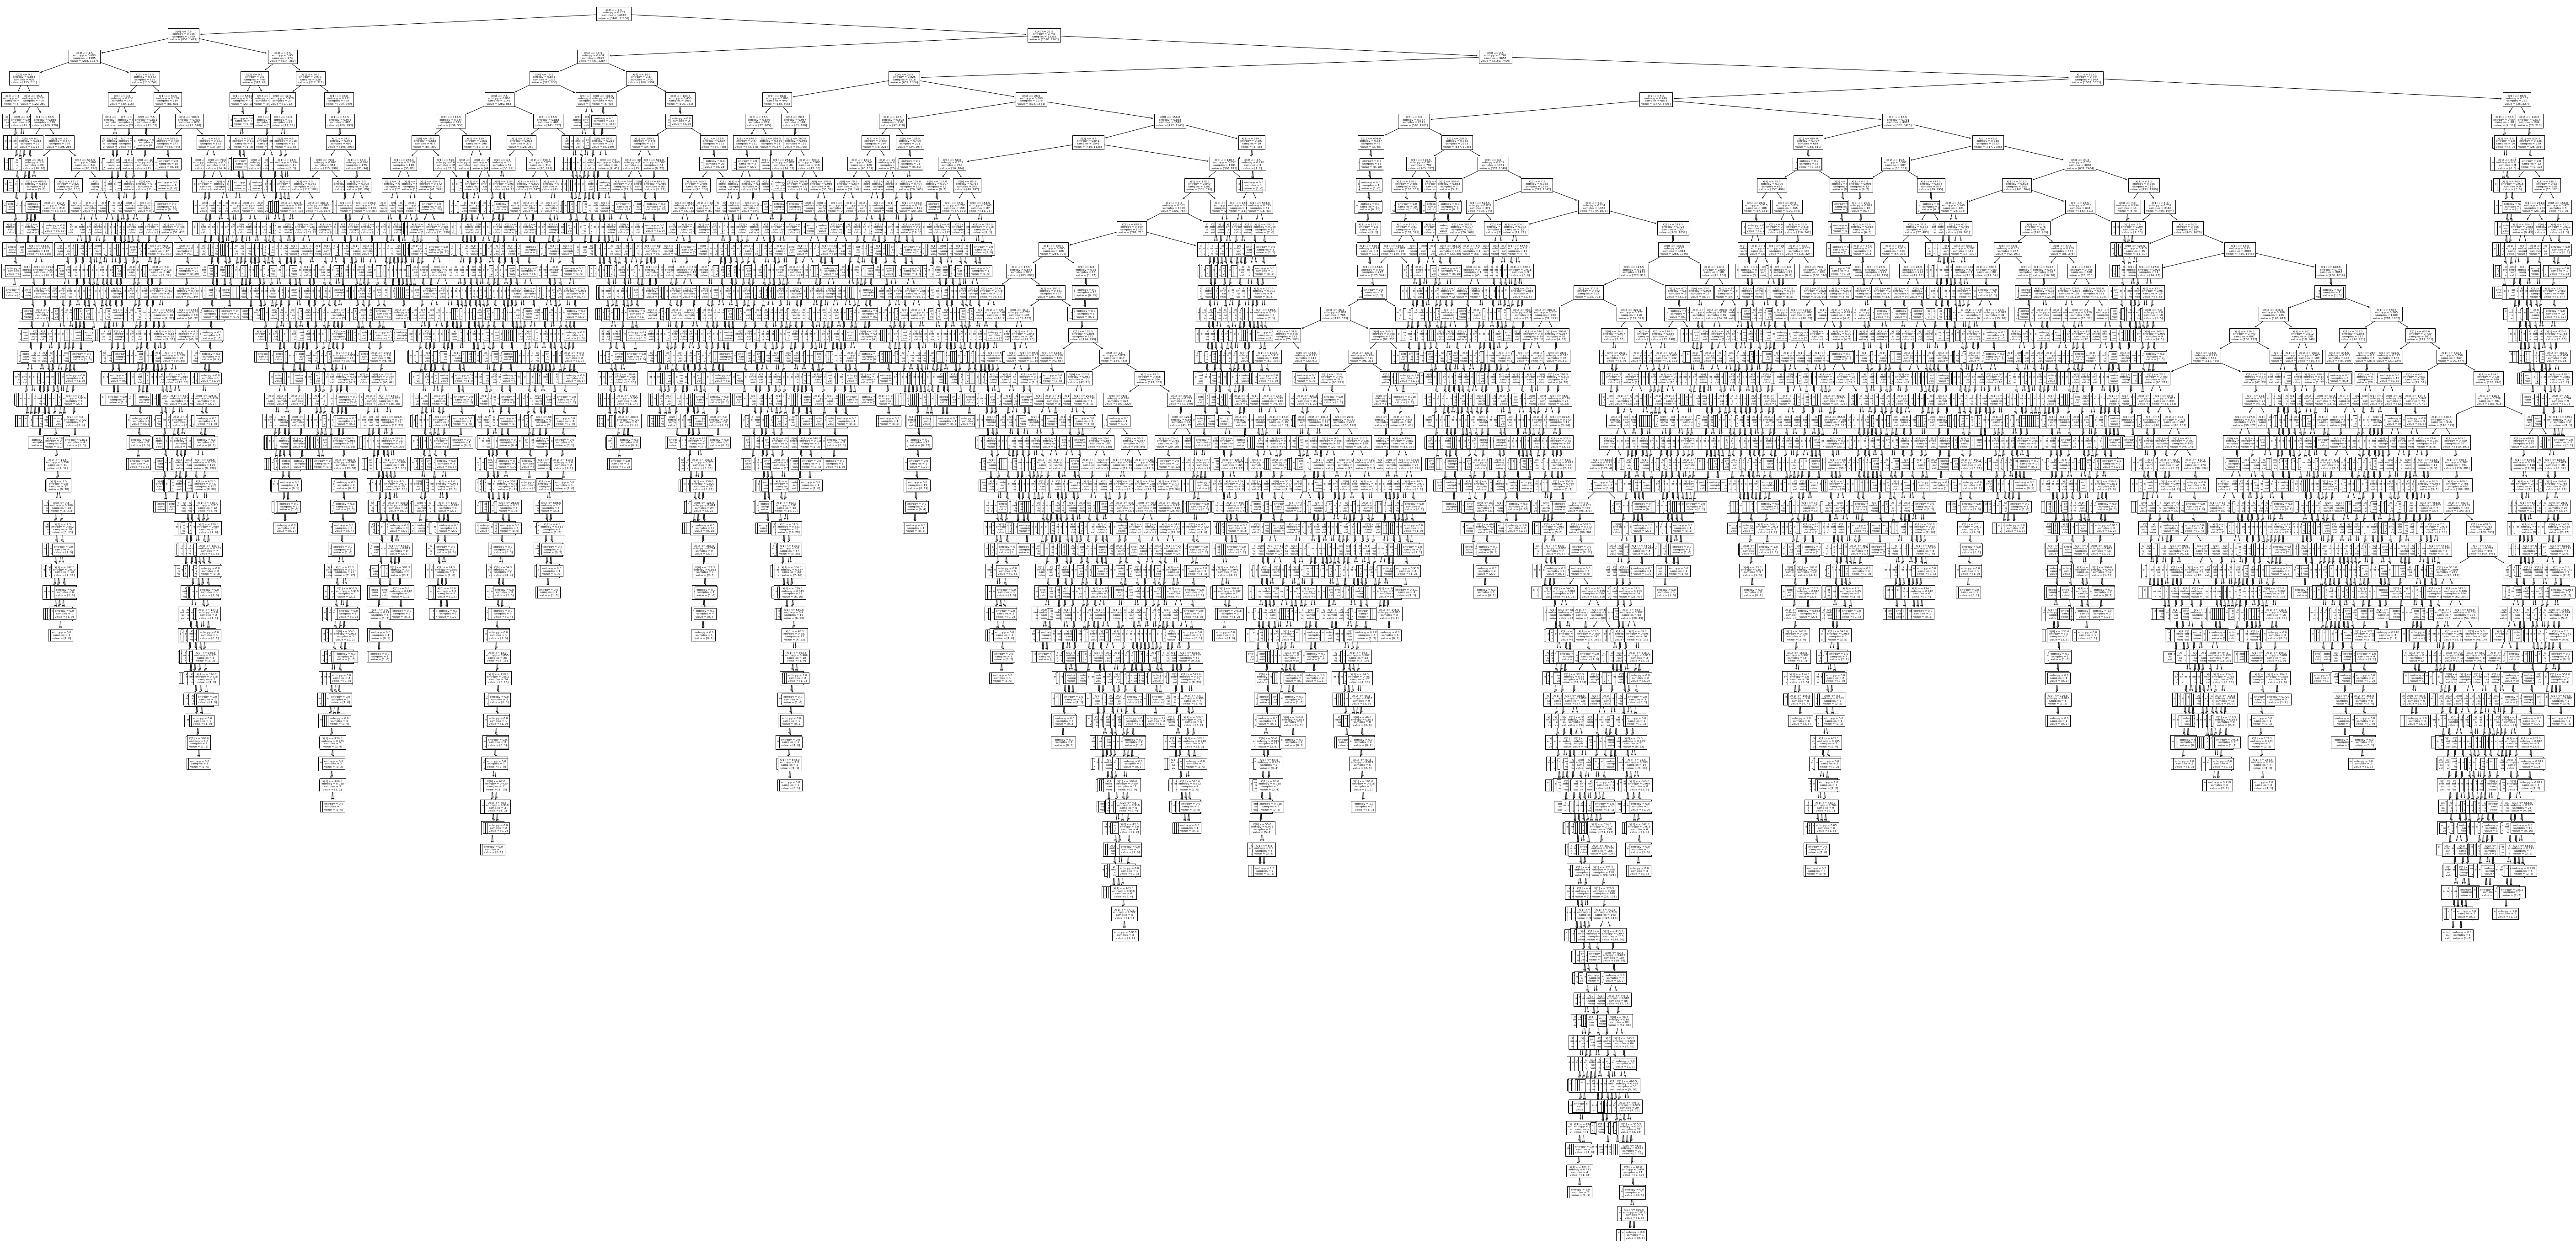

In [37]:
# plotting decision tree

fig, ax = plt.subplots(figsize=(100, 50))
tree.plot_tree(clf, fontsize=6)
plt.savefig('1', dpi=100)